In [0]:
import re
import nltk
import pickle
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
!python -m nltk.downloader stopwords wordnet punkt averaged_perceptron_tagger
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.layers import Attention
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
!pip install rouge
from rouge import Rouge

/usr/lib/python3.6/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Using TensorFlow backend.


### Hyperparameters

In [0]:
BATCH_SIZE=30
EPOCHS=50
latent_dim=128
embedding_dim=128
test_train_split=0.15
build_number="1"
LEARNING_RATE=0.0005
max_text_len = 20
max_summary_len = 10
UNCOMMON_WORD_THRESHOLD = 100

In [0]:
# create rouge object for evaluation
rouge = Rouge()

## Data Processing

Read In Data

In [0]:
# Only needed if running on Google Colab
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
df = pd.read_csv('./drive/My Drive/all.csv')
df.head(1)

,Unnamed: 0,file,text,summary
0,0,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4.story,LONDON England Reuters Harry Potter star Danie...,Harry Potter star Daniel Radcliffe gets 20M fo...


In [0]:
df.count

<bound method DataFrame.count of        Unnamed: 0  ...                                            summary
0               0  ...  Harry Potter star Daniel Radcliffe gets 20M fo...
1               1  ...  Mentally ill inmates Miami housed forgotten fl...
2               2  ...  NEW I thought I going die driver says Man says...
3               3  ...  Five small polyps found procedure none worriso...
4               4  ...  NEW NFL chief Atlanta Falcons owner critical M...
...           ...  ...                                                ...
92574       92574  ...  Cape Town students demand Cecil Rhodes statue ...
92575       92575  ...  More people displaced live Moscow people lost ...
92576       92576  ...  Dzhokhar Tsarnaev trial alleged role Boston Ma...
92577       92577  ...  Rabea Dardunas Gaza home destroyed last year s...
92578       92578  ...  Saudi minister If wars drums beaten ready U.N....

[92579 rows x 4 columns]>

In [0]:
df.head()

,Unnamed: 0,file,text,summary
0,0,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4.story,LONDON England Reuters Harry Potter star Danie...,Harry Potter star Daniel Radcliffe gets 20M fo...
1,1,ee8871b15c50d0db17b0179a6d2beab35065f1e9.story,Editors note In Behind Scenes series CNN corre...,Mentally ill inmates Miami housed forgotten fl...
2,2,06352019a19ae31e527f37f7571c6dd7f0c5da37.story,MINNEAPOLIS Minnesota Drivers Minneapolis brid...,NEW I thought I going die driver says Man says...
3,3,24521a2abb2e1f5e34e6824e0f9e56904a2b0e88.story,WASHINGTON Doctors remove five small polyp Pre...,Five small polyps found procedure none worriso...
4,4,7fe70cc8b12fab2d0a258fababf7d9c6b5e1262a.story,The National Football League indefinitely susp...,NEW NFL chief Atlanta Falcons owner critical M...


Remove .'s that appear in stuff like U.S.A and U.N - Eventually need to move this to dataprocessing.py

In [0]:
print(df['summary'][0])
df['summary'] = df['summary'].apply(lambda x: re.sub(r'\..*$',' ',str(x)))
print(df['summary'][0])

Harry Potter star Daniel Radcliffe gets 20M fortune turns 18 Monday Young actor says plans fritter cash away Radcliffes earnings first five Potter films held trust fund
Harry Potter star Daniel Radcliffe gets 20M fortune turns 18 Monday Young actor says plans fritter cash away Radcliffes earnings first five Potter films held trust fund


In [0]:
print(df['summary'][0])
df['summary'] = df['summary'].apply(lambda x: re.sub(r'\.','',str(x)))
print(df['summary'][0])

Harry Potter star Daniel Radcliffe gets 20M fortune turns 18 Monday Young actor says plans fritter cash away Radcliffes earnings first five Potter films held trust fund
Harry Potter star Daniel Radcliffe gets 20M fortune turns 18 Monday Young actor says plans fritter cash away Radcliffes earnings first five Potter films held trust fund


Check for rows with null values in them, and copy these into a new dataframe (df1). Drop any rows in df1 from df to ensure no NaN valued rows are present/

*Note. using simply dropna(how='any') does not seem to drop any of the rows*

In [0]:
print(df.isnull().values.any())
print(df.shape)

df1 = df[df.isna().any(axis=1)]
print(df1.shape)

df.drop(df1.index, axis=0,inplace=True)
print(df.shape)
print(df.isnull().values.any())

True
(92579, 4)
(114, 4)
(92465, 4)
False


In [0]:
# only keep first x words (defined by max_text_len)
print(df['text'][0])
df['text'] = df['text'].apply(lambda x: nltk.word_tokenize(x)).apply(lambda x: " ".join(x[:max_text_len]))
print(df['text'][0])

LONDON England Reuters Harry Potter star Daniel Radcliffe gain access report 20 million 411 million fortune turn 18 Monday insists money wont cast spell Daniel Radcliffe Harry Potter Harry Potter Order Phoenix To disappointment gossip columnist around world young actor say plan fritter cash away fast car drink celebrity party I dont plan one people soon turn 18 suddenly buy massive sport car collection something similar told Australian interviewer earlier month I dont think Ill particularly extravagant The thing I like buying thing cost 10 pound book CDs DVDs At 18 Radcliffe able gamble casino buy drink pub see horror film Hostel Part II currently six place number one movie UK box office chart Details hell mark landmark birthday wrap His agent publicist comment plan Ill definitely sort party say interview Hopefully none reading Radcliffes earnings first five Potter film held trust fund able touch Despite grow fame rich actor say keep foot firmly ground People always look say kid star g

In [0]:
print(df['summary'][0])
df['summary'] = df['summary'].apply(lambda x: nltk.word_tokenize(x)).apply(lambda x: " ".join(x[:max_summary_len]))
print(df['summary'][0])

Harry Potter star Daniel Radcliffe gets 20M fortune turns 18 Monday Young actor says plans fritter cash away Radcliffes earnings first five Potter films held trust fund
Harry Potter star Daniel Radcliffe gets 20M fortune turns 18


Word Count Distribution

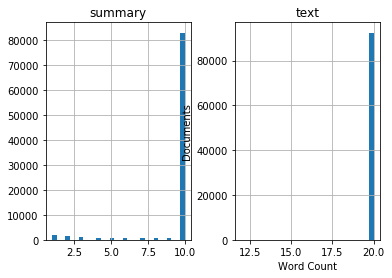

In [0]:
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in df['text']:
      text_word_count.append(len(i.split(' ')))

for i in df['summary']:
      summary_word_count.append(len(i.split(' ')))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.ylabel('Documents')
plt.xlabel('Word Count')
# plt.savefig('word_count_distro' + str(build_number) + '.png')
plt.show()

Max Text Lengths

In [0]:
max_text_len = max([len(txt.split(' ')) for txt in df['text']])
max_summary_len = max([len(txt.split(' ')) for txt in df['summary']])
print(max_text_len)
print(max_summary_len)

20
10


### Removing Common Words

In [0]:
x_word_dict = {}
text = df['text'].apply(lambda x: nltk.word_tokenize(x))

for index, row in text.iteritems():
  for word in row:
    if word not in x_word_dict.keys():
      x_word_dict[word] = 1
    else:
      x_word_dict[word] += 1

print(len(x_word_dict))
x_sorted_dict = sorted(x_word_dict.items(), key=lambda x: x[1], reverse=True)
print(x_sorted_dict)
x, y = zip(*x_sorted_dict)

74329
[('The', 27452), ('say', 15825), ('A', 12506), ('year', 8036), ('one', 6812), ('US', 6621), ('New', 6088), ('people', 6036), ('two', 5476), ('Tuesday', 5400), ('new', 5346), ('President', 5330), ('Wednesday', 5263), ('Thursday', 5077), ('week', 4974), ('first', 4910), ('kill', 4873), ('Washington', 4868), ('Monday', 4855), ('Friday', 4767), ('world', 4627), ('day', 4512), ('I', 4476), ('take', 4328), ('official', 4258), ('make', 4246), ('police', 4039), ('country', 4021), ('In', 3971), ('last', 3928), ('Sunday', 3827), ('man', 3739), ('time', 3712), ('United', 3663), ('Saturday', 3591), ('York', 3489), ('woman', 3249), ('go', 3212), ('government', 3168), ('Obama', 3159), ('get', 3136), ('accord', 3100), ('But', 3062), ('month', 2955), ('report', 2921), ('death', 2919), ('former', 2909), ('It', 2901), ('call', 2874), ('come', 2867), ('CNN', 2779), ('show', 2777), ('home', 2706), ('state', 2686), ('South', 2642), ('California', 2631), ('die', 2621), ('charge', 2565), ('three', 2542

In [0]:
# only accept words that occur more than 100 times
accept_words = []
for word, occ in x_sorted_dict:
  if int(occ) > UNCOMMON_WORD_THRESHOLD:
    accept_words.append(word)
  else:
    break
     
#remove first three comon words
# accept_words.remove(list(x[:3]))
accept_words = [x.lower() for x in accept_words]
print(accept_words)
print(df['text'][2])
df['text'] = df['text'].apply(lambda x: nltk.word_tokenize(x)).apply(lambda x: " ".join([word for word in x if word.lower() in accept_words]))
print(df['text'][2])

['the', 'say', 'a', 'year', 'one', 'us', 'new', 'people', 'two', 'tuesday', 'new', 'president', 'wednesday', 'thursday', 'week', 'first', 'kill', 'washington', 'monday', 'friday', 'world', 'day', 'i', 'take', 'official', 'make', 'police', 'country', 'in', 'last', 'sunday', 'man', 'time', 'united', 'saturday', 'york', 'woman', 'go', 'government', 'obama', 'get', 'accord', 'but', 'month', 'report', 'death', 'former', 'it', 'call', 'come', 'cnn', 'show', 'home', 'state', 'south', 'california', 'die', 'charge', 'three', 'american', 'know', 'authority', 'would', 'announce', 'may', 'city', 'london', 'attack', 'like', 'states', 'could', 'its', 'group', 'found', 'leader', 'barack', 'use', 'night', 'million', 'england', 'military', 'child', 'arrest', 'life', 'least', 'as', 'world', 'family', 'los', 'late', 'end', 'when', 'many', 'release', 'force', 'told', 'angeles', 'back', 'become', 'work', 'look', 'face', 'an', 'ago', 'court', 'lead', 'star', 'top', 'nation', 'see', 'north', 'way', 'help', '

In [0]:
x_word_dict_after = {}
text = df['text'].apply(lambda x: nltk.word_tokenize(x))

for index, row in text.iteritems():
  for word in row:
    if word not in x_word_dict_after.keys():
      x_word_dict_after[word] = 1
    else:
      x_word_dict_after[word] += 1

print(len(x_word_dict_after))

4847


In [0]:
y_word_dict = {}
text = df['summary'].apply(lambda x: nltk.word_tokenize(x))

for index, row in text.iteritems():
  for word in row:
    if word not in y_word_dict.keys():
      y_word_dict[word] = 1
    else:
      y_word_dict[word] += 1

print(len(y_word_dict))
y_sorted_dict = sorted(y_word_dict.items(), key=lambda x: x[1], reverse=True)
print(y_sorted_dict)
x, y = zip(*y_sorted_dict)

67110
[('The', 16050), ('says', 11825), ('NEW', 11300), ('A', 4773), ('U', 4626), ('He', 3154), ('say', 3070), ('new', 2586), ('people', 2487), ('Obama', 2348), ('New', 2291), ('first', 2198), ('President', 1906), ('two', 1748), ('one', 1738), ('years', 1646), ('police', 1625), ('killed', 1553), ('She', 1399), ('Police', 1385), ('CNN', 1371), ('World', 1282), ('found', 1263), ('It', 1232), ('In', 1169), ('show', 1164), ('said', 1128), ('death', 1117), ('year', 1093), ('South', 1050), ('last', 1050), ('official', 1020), ('man', 1013), ('world', 982), ('died', 975), ('president', 950), ('government', 940), ('Two', 936), ('I', 935), ('could', 914), ('One', 912), ('This', 912), ('group', 901), ('three', 899), ('home', 886), ('time', 875), ('help', 875), ('United', 863), ('family', 861), ('10', 854), ('officials', 852), ('Some', 847), ('They', 847), ('John', 830), ('since', 815), ('million', 813), ('An', 809), ('least', 807), ('arrested', 793), ('Cup', 787), ('week', 785), ('House', 780), (

In [0]:
# only accept words that occur more than 100 times
accept_words = []
for word, occ in y_sorted_dict:
  if int(occ) > UNCOMMON_WORD_THRESHOLD:
    accept_words.append(word)
  else:
    break
     
# accept_words.remove(list(x[:3]))
accept_words = [x.lower() for x in accept_words]
print(accept_words)
print(df['summary'][2])
df['summary'] = df['summary'].apply(lambda x: nltk.word_tokenize(x)).apply(lambda x: " ".join([word for word in x if word.lower() in accept_words]))
print(df['summary'][2])

['the', 'says', 'new', 'a', 'u', 'he', 'say', 'new', 'people', 'obama', 'new', 'first', 'president', 'two', 'one', 'years', 'police', 'killed', 'she', 'police', 'cnn', 'world', 'found', 'it', 'in', 'show', 'said', 'death', 'year', 'south', 'last', 'official', 'man', 'world', 'died', 'president', 'government', 'two', 'i', 'could', 'one', 'this', 'group', 'three', 'home', 'time', 'help', 'united', 'family', '10', 'officials', 'some', 'they', 'john', 'since', 'million', 'an', 'least', 'arrested', 'cup', 'week', 'house', 'state', 'american', 'north', 'at', 'report', 'calls', 'david', 'china', 'would', 'no', 'win', 'made', 'former', 'michael', 'former', 'may', 'attack', 'court', 'accused', 'more', 'british', 'york', 'transcript', 'wins', 'shows', 'military', 'its', 'women', 'dead', 'set', 'sunday', 'top', 'woman', 'back', 'monday', 'second', 'we', 'children', 'four', 'take', 'video', 'friday', 'get', 'leader', '20', 'there', 'media', 'charged', 'tells', 'tuesday', 'case', 'many', 'make', 's

In [0]:
y_word_dict_after = {}
summary = df['summary'].apply(lambda x: nltk.word_tokenize(x))

for index, row in summary.iteritems():
  for word in row:
    if word not in y_word_dict_after.keys():
      y_word_dict_after[word] = 1
    else:
      y_word_dict_after[word] += 1
print(len(y_word_dict_after))

2534


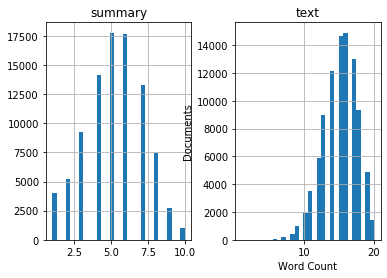

In [0]:
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in df['text']:
      text_word_count.append(len(i.split(' ')))

for i in df['summary']:
      summary_word_count.append(len(i.split(' ')))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.ylabel('Documents')
plt.xlabel('Word Count')
# plt.savefig('word_count_distro' + str(build_number) + '.png')
plt.show()

In [0]:
# update max text lengths
max_text_len = max([len(txt.split(' ')) for txt in df['text']])
max_summary_len = max([len(txt.split(' ')) for txt in df['summary']])
print(max_text_len)
print(max_summary_len)

20
10


In [0]:
# drop any lines that have no text or summary after the word removal process
print(df.isnull().values.any())
print(df.shape)

df1 = df[df.isna().any(axis=1)]
print(df1.shape)

df.drop(df1.index, axis=0,inplace=True)
print(df.shape)
print(df.isnull().values.any())

False
(92465, 4)
(0, 4)
(92465, 4)
False


### Training-Validation Split

X - Articles text </br>
Y - Summaries

In [0]:
# convert to numpy array
X = np.array(df['text'])
Y = np.array(df['summary'])

In [0]:
x_tr,x_val,y_tr,y_val=train_test_split(X,Y,test_size=test_train_split,random_state=0,shuffle=True)
print(x_tr.shape)
print(x_val.shape)
print(y_tr.shape)
print(y_val.shape)

(78595,)
(13870,)
(78595,)
(13870,)


### Word Embeddings - Tokenization

X Tokenizer

In [0]:
word_dict = {}
text = df['text']

for row in text: 
  for word in row.split(" "):
    if word not in word_dict:
      word_dict[word] = 1
    else:
      word_dict[word] += 1

print(len(word_dict))

4848


In [0]:
# #prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=len(word_dict), split=" ") 
x_tokenizer.fit_on_texts(list(X))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1
print(x_voc)

4849


In [0]:
# with open('xtokenizer.pickle', 'wb') as handle:
#   pickle.dump(x_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

Y Tokenizer

In [0]:
y_word_dict = {}
summ = df['summary']

for row in summ: 
  for word in row.split(" "):
    if word not in y_word_dict:
      y_word_dict[word] = 1
    else:
      y_word_dict[word] += 1

print(len(y_word_dict))

2535


In [0]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=len(y_word_dict), split=" ") 
y_tokenizer.fit_on_texts(list(Y))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words + 1
print(y_voc)

2536


In [0]:
# with open('ytokenizer.pickle', 'wb') as handle:
#   pickle.dump(y_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Learning Model

#### Encoder Model

In [0]:
# bidirectional
encoder_inputs = Input(shape=(max_text_len,), name="encoder_input")
#embedding layer
enc_emb =  Embedding(x_voc,embedding_dim,trainable=True,name="encoder_embedding")(encoder_inputs)
#encoder lstm 
encoder_lstm = Bidirectional(LSTM(latent_dim,return_sequences=True,return_state=True, name="bidirectional_lstm"))
encoder_outputs, fw_state_h, fw_state_c, bw_state_h, bw_state_c = encoder_lstm(enc_emb)

state_h = Concatenate()([fw_state_h, bw_state_h])
state_c = Concatenate()([fw_state_c, bw_state_c])
encoder_states = [state_h, state_c]

#### Decoder Model

In [0]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,), name="decoder_input")

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True,name="decoder_embedding")
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True, name="decoder_lstm")
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=encoder_states)
                                                          
#dense layer
#soft max creates a prob vector that allows us to determine the final output
decoder_dense = Dense(y_voc, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

#### Combined LSTM Model

In [0]:
# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 20)           0                                            
__________________________________________________________________________________________________
encoder_embedding (Embedding)   (None, 20, 128)      620672      encoder_input[0][0]              
__________________________________________________________________________________________________
decoder_input (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 20, 256), (N 263168      encoder_embedding[0][0]          
____________________________________________________________________________________________

In [0]:
optimizer = RMSprop(lr=LEARNING_RATE, rho=0.9)

In [0]:
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')

- Early Stopping Callback to ensure we stop when Validation Loss is lowest - minimises risk of overfitting
- Model Checkpoint saves the model after each epoch so that we can load the model with the best weights later on. Alternatively, it allows us to continue training the model at a later data



In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2, restore_best_weights=False)
filepath = "./drive/My Drive/project-model/saved-model-{epoch:02d}.hdf5"
mc = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

#### Use this method to train a new model. To continue training a previously trained model see below

In [0]:
y_tr_3d = y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:]
y_val_3d = y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]

In [0]:
print(x_tr.shape)
print(y_tr.shape)
print(y_tr_3d.shape)
print(x_val.shape)
print(y_val.shape)
print(y_val_3d.shape)

(78595, 20)
(78595, 10)
(78595, 9, 1)
(13870, 20)
(13870, 10)
(13870, 9, 1)


In [0]:
history = model.fit([x_tr,y_tr[:,:-1]], y_tr_3d, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[es,mc], 
                    validation_data=([x_val,y_val[:,:-1]], y_val_3d))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 78595 samples, validate on 13870 samples
Epoch 1/50





78595/78595 [==============================] - 241s 3ms/step - loss: 3.3421 - val_loss: 3.2108
Epoch 2/50
78595/78595 [==============================] - 230s 3ms/step - loss: 3.1616 - val_loss: 3.0948
Epoch 3/50
78595/78595 [==============================] - 229s 3ms/step - loss: 3.0544 - val_loss: 3.0183
Epoch 4/50
78595/78595 [==============================] - 230s 3ms/step - loss: 2.9755 - val_loss: 2.9687
Epoch 5/50
78595/78595 [==============================] - 230s 3ms/step - loss: 2.9146 - val_loss: 2.9310
Epoch 6/50
78595/78595 [==============================] - 231s 3ms/step - loss: 2.8661 - val_loss: 2.9078
Epoch 7/50
78595/78595 [==============================] - 231s 3ms/step - loss: 2.8261 - val_loss: 2.8951
Epoch 8/50
78595/78595 [==============================] - 229s 3ms/step - loss: 2.7869 - val_loss: 2.8814


#### This method is to only be used when loading a previously partially trained model

In [0]:
# model = load_model("./drive/My Drive/project-model/saved-model-53.hdf5")
# history = model.fit([x_tr,y_tr[:,:-1]], y_tr, callbacks=[mc], batch_size=BATCH_SIZE, epochs=1, validation_data=([x_val,y_val[:,:-1]], y_val))

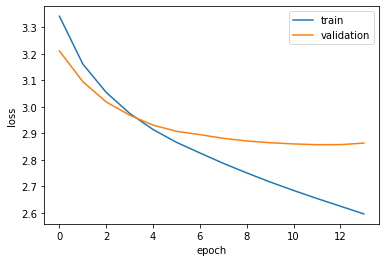

In [0]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
# plt.savefig('loss' + str(build_number) + '.png')
plt.show()

## Inference Model

In [0]:
# load model from drive
# model = load_model("./drive/My Drive/saved-model-53.hdf5")

In [0]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
print(reverse_source_word_index)
print(reverse_target_word_index)

{1: 'the', 2: 'say', 3: 'a', 4: 'new', 5: 'one', 6: 'year', 7: 'us', 8: 'president', 9: 'two', 10: 'world', 11: 'washington', 12: 'people', 13: 'tuesday', 14: 'wednesday', 15: 'day', 16: 'first', 17: 'police', 18: 'thursday', 19: 'week', 20: 'kill', 21: 'monday', 22: 'friday', 23: 'i', 24: 'take', 25: 'last', 26: 'make', 27: 'official', 28: 'country', 29: 'york', 30: 'in', 31: 'state', 32: 'man', 33: 'city', 34: 'sunday', 35: 'time', 36: 'former', 37: 'united', 38: 'london', 39: 'saturday', 40: 'woman', 41: 'go', 42: 'government', 43: 'get', 44: 'obama', 45: 'three', 46: 'accord', 47: 'but', 48: 'call', 49: 'month', 50: 'death', 51: 'show', 52: 'report', 53: 'it', 54: 'come', 55: 'south', 56: 'may', 57: 'cnn', 58: 'home', 59: 'court', 60: 'california', 61: 'die', 62: 'like', 63: 'authority', 64: 'charge', 65: 'news', 66: 'know', 67: 'american', 68: 'would', 69: 'los', 70: 'announce', 71: 'group', 72: 'angeles', 73: 'national', 74: 'could', 75: 'attack', 76: 'leader', 77: 'night', 78: '

In [0]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

In [0]:
encoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 20)           0                                            
__________________________________________________________________________________________________
encoder_embedding (Embedding)   (None, 20, 128)      620672      encoder_input[0][0]              
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 20, 256), (N 263168      encoder_embedding[0][0]          
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 256)          0           bidirectional_1[0][1]            
                                                                 bidirectional_1[0][3]      

In [0]:
# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim*2,))
decoder_state_input_c = Input(shape=(latent_dim*2,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim*2))
decoder_state_inputs = [decoder_state_input_h, decoder_state_input_c]

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_state_inputs)
decoder_states = [state_h2, state_c2]
# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c], [decoder_outputs2] + decoder_states)
# decoder_model = Model([decoder_inputs] + decoder_state_inputs, [decoder_outputs2] + decoder_states)


In [0]:
decoder_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
decoder_embedding (Embedding)   (None, None, 128)    324608      decoder_input[0][0]              
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 256)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 256)          0                                            
____________________________________________________________________________________________

### Methods for Reversing Word Embeddings

In [0]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

### Summarisation Method 

In [0]:
## selects the most probable word using argmax
def decode_sequence(input_seq): 
    # Encode the input as state vectors.
    # print(input_seq)
    # print(input_seq.shape)
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, y_voc))
    # print(target_seq.shape)
    stop_condition = False
    decoded_sentence = ''
    # last_token = 0
    while not stop_condition:
      # Model([decoder_inputs] + decoder_state_inputs, [decoder_outputs2] + decoder_states)
      output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c]) 
      sampled_token_index = np.argmax(output_tokens[0, -1, :][1:])
      # if(sampled_token_index == last_token):
      #   a = np.delete(output_tokens[0, -1, :][1:], sampled_token_index)
      #   sampled_token_index=np.argmax(a)
      #   if sampled_token_index >= last_token :
      #     sampled_token_index = sampled_token_index+1 
      # print(sampled_token_index)
      # print(sampled_token_index)
      # last_token = sampled_token_index
      if (sampled_token_index != 0 ):
        sampled_token = reverse_target_word_index[sampled_token_index]
        # print(sampled_token)
        decoded_sentence += ' '+sampled_token
      else :
        print("sadface")
        stop_condition = True
      if (len(decoded_sentence.split()) >= (max_summary_len-1)):
              stop_condition = True
       # Update the target sequence (of length 1).
      # target_seq = np.zeros((1,1))
      target_seq = np.zeros((1, y_voc))
      target_seq[0, sampled_token_index] = 1
      # print(target_seq)
      # Update internal states
      e_h, e_c = h, c
      
    return decoded_sentence

## Test Model Output

Note: *I think there isn't enough data being passed in and so the argmax value always is 0 - it can't learn what should be next*

In [0]:
def getRouge(gt, pred):
  return rouge.get_scores(pred, gt)

In [0]:
for i in range(0,5):
    print("Article:",seq2text(x_tr[i]))
    original = seq2summary(y_tr[i])
    if (original !=""):
      print("Original summary:",original)
      a = x_tr[i].reshape(1,max_text_len)
      summary = decode_sequence(a)
      print("Generated summary:",summary)
      print("\n")

      if summary != "":    
        print("ROUGE score: ")
        score = getRouge(str(summary), str(original))
        print(score)
        print(score[0].get('rouge-1').get('f'))
        print(score[0].get('rouge-1').get('p'))
        print(score[0].get('rouge-1').get('r'))

Article: hundreds hit street moscow sunday rally promote peace response violence unrest staterun medium report the moscow 
Original summary: about people attend media reports 
Generated summary:  new new new new new new new new new


ROUGE score: 
[{'rouge-1': {'f': 0.0, 'p': 0.0, 'r': 0.0}, 'rouge-2': {'f': 0.0, 'p': 0.0, 'r': 0.0}, 'rouge-l': {'f': 0.0, 'p': 0.0, 'r': 0.0}}]
0.0
0.0
0.0
Article: search rescue team friday try reach airplane crashed 18 people aboard mountain western indonesia air transportation official say air traffic 
Original summary: the carrying 14 people crashed north air 
Generated summary:  new the the the the the the the new


ROUGE score: 
[{'rouge-1': {'f': 0.22222221876543213, 'p': 0.14285714285714285, 'r': 0.5}, 'rouge-2': {'f': 0.0, 'p': 0.0, 'r': 0.0}, 'rouge-l': {'f': 0.15099715099682406, 'p': 0.14285714285714285, 'r': 0.5}}]
0.22222221876543213
0.14285714285714285
0.5
Article: its easy take lot vacation picture organize something else here favorite sho

## Evaluation

Using ROUGE (Recall-Orientated Understanding Gisting Evaluation) to evaluate the generated summaries.

*Note: This takes a long time, especially with large datasets* 

In [0]:
def get_overlapping_words(x, y):
  num=0
  x = nltk.word_tokenize(x)
  y = nltk.word_tokenize(y)
  for word in y:
    if word in x:
      num = num+1
      x.remove(word)
    else:
      return num

def precision(target, generated):
  length = len(target)
  for i in range (0, length):
    num_overlapping_words = get_overlapping_words(target[i], generated[i])
    generated_summary_len = len(generated[i])
    if generated_summary_len == 0 :
        return 0.0
    else : 
      return num_overlapping_words / generated_summary_len

### For Training Data

In [0]:
print(len(x_tr))

78595


In [0]:
tr_target_summary = []
tr_generated_summary = []
x_tr_len = len(x_tr)

f_ov = 0
p_ov = 0
r_ov = 0
# x_val_len = 1
for i in range(0,x_tr_len):
  original = seq2summary(y_tr[i])
  if original != "" :
    tr_target_summary.append(original)
    x_i = x_tr[i].reshape(1,max_text_len)
    summary = decode_sequence(x_i)
    tr_generated_summary.append(summary)
    score = getRouge(str(summary), str(original))
    f_ov += float(score[0].get('rouge-1').get('f'))
    p_ov += float(score[0].get('rouge-1').get('p'))
    r_ov += float(score[0].get('rouge-1').get('r'))

In [0]:
# print("precision : " + str(precision(tr_target_summary, tr_generated_summary)))
print("Avg F Score: " + str(f_ov/x_tr_len))
print("Avg Precision: " + str(p_ov/x_tr_len))
print("Avg Recall: " + str(r_ov/x_tr_len))

### For Validation Data

In [0]:
val_target_summary = []
val_generated_summary = []
x_val_len = len(x_val)
f_ov = 0
p_ov = 0
r_ov = 0

for i in range(0,x_val_len):
  original = seq2summary(y_val[i])
  val_target_summary.append(original)
  x_i = x_val[i].reshape(1,max_text_len)
  # summary = decode_sequence(x_i)
  summary = "new new new new new new new new new"
  val_generated_summary.append(summary)
  score = getRouge(str(summary), str(original))
  f_ov += float(score[0].get('rouge-1').get('f'))
  p_ov += float(score[0].get('rouge-1').get('p'))
  r_ov += float(score[0].get('rouge-1').get('r'))

In [0]:
# print("precision : " + str(precision(val_target_summary, val_generated_summary)))
print("Avg F Score: " + str(f_ov/x_val_len))
print("Avg Precision: " + str(p_ov/x_val_len))
print("Avg Recall: " + str(r_ov/x_val_len))

# Inputting New Data

In [0]:
def getpos(word):
  pos = nltk.pos_tag([word])[0][1][0]
  wordnet_conv = {"J": wn.ADJ, "N": wn.NOUN, "V": wn.VERB, "R": wn.ADV}
  if pos in wordnet_conv.keys():
    return wordnet_conv.get(pos)
  return ""

In [0]:
def lemmatization(text):
  lemmatizer = WordNetLemmatizer()
  text_tokenized = inp_df['text'].apply(lambda x: nltk.word_tokenize(x))
  print("lemmatize with pos")
  for i in range(0,len(text_tokenized)):
    text_lemmatized = []
    for word in text_tokenized[i]:
      pos = getpos(word)
      if pos != "":
        lemma = lemmatizer.lemmatize(word, pos)
        text_lemmatized.append(lemma)
      else :
        text_lemmatized.append(word)
    text_lemmatized = ' '.join(map(str, text_lemmatized))
    inp_df['text'][i] = text_lemmatized


In [0]:
# input1 = "(CNN) — Earlier this year, Delta Air Lines announced a rethink on reclining seats. In an effort to disrupt fewer passengers' travel experiences, Delta said it'd begin revamping some of its jets to reduce the recline of coach seats from four inches to two inches and the recline of first class seats from 5.5 inches to 3.5 inches. For those who abhor the recline option, it's a small step. And for those who value it, well, it's a compromise. This seemingly innocuous topic is one where there are very much two minds on what's acceptable and what's not. Two CNN Travel staffers engage in a friendly debate about seat recline. Your seat. Your decision. Stacey Lastoe, senior editor at CNN Travel, is of above-average height and makes no apology about reclining; it's her right as a plane, train and bus passenger. She encourages the person sitting in front of her to recline as well. On the first leg of my flight to Japan for my honeymoon, my husband and I got upgraded to first class. Although it would just be a few hours in the sky en route to Dallas, I was excited about sipping Champagne, sitting back and relaxing. Flute in hand, I pushed back to recline my seat for maximum relaxation. But it would not budge; I appeared to be stuck in a dysfunctional seat. Or was I? Turns out the gentleman behind me had a dog in a crate down between his legs, positioned so the seat in front of his -- my seat -- had nowhere to go. Because we were newlyweds and loving every moment of it, I did not mind when my husband turned to the man and told him his wife wanted to recline her seat and asked if he could please rearrange his dog crate to allow for everyones comfort."
input1 = "Its official US President Barack Obama want lawmaker weigh whether use military force Syria Obama sent letter head House Senate Saturday night hour announce believe military action Syrian target right step take allege use chemical weapon The propose legislation Obama asks Congress approve use military force deter disrupt prevent degrade potential future us chemical weapon weapon mass destruction Its step set turn international crisis fierce domestic political battle There key question loom debate What UN weapon inspector find Syria What happens Congress vote And Syrian government react In televise address White House Rose Garden earlier Saturday president say would take case Congress want While I believe I authority carry military action without specific congressional authorization I know country strong take course action even effective say We debate issue big business usual Obama say top congressional leader agree schedule debate body return Washington September 9 The Senate Foreign Relations Committee hold hearing matter Tuesday Sen Robert Menendez say Transcript Read Obamas full remark Syrian crisis Latest development UN inspector leave Syria Obamas remark come shortly UN inspector left Syria carry evidence determine whether chemical weapon use attack early last week Damascus suburb The aim game mandate clear ascertain whether chemical weapon use UN spokesman Martin Nesirky told reporter Saturday But use weapon report toxic gas attack Damascus suburb August 21 key point global debate Syrian crisis Top US official say there doubt Syrian government behind Syrian official deny responsibility blame jihadist fight rebel British US intelligence report say attack involve chemical weapon UN official stress importance wait official report inspector The inspector share finding UN SecretaryGeneral Ban Kimoon Ban say want wait UN team final report complete present UN Security Council The Organization Prohibition Chemical Weapons nine inspector belong say Saturday could take three week analyze evidence collect It need time able analyze information sample Nesirky say He note Ban repeatedly say alternative political solution crisis Syria military solution option Bergen Syria problem hell US Obama This menace must confront Obamas senior adviser debate next step take president comment Saturday come amid mount political pressure situation Syria Some US lawmaker call immediate action others warn step could become quagmire Some global leader express support British Parliaments vote military action earlier week blow Obamas hope get strong backing key NATO ally On Saturday Obama propose say would limited military action Syrian President Bashar alAssad Any military attack would openended include US ground force say Syrias allege use chemical weapon earlier month assault human dignity president say A failure respond force Obama argue could lead escalate use chemical weapon proliferation terrorist group would people harm In world many danger menace must confront Syria missile strike What would happen next Map US allied asset around Syria Obama decision come Friday night On Friday night president make lastminute decision consult lawmaker What happen vote Its unclear A senior administration official told CNN Obama authority act without Congress even Congress reject request authorization use force Obama Saturday continued shore support strike alAssad government He spoke phone French President Francois Hollande Rose Garden speech The two leader agree international community must deliver resolute message Assad regime others would consider use chemical weapon crime unacceptable violate international norm held accountable world White House say Meanwhile uncertainty loom Congress would weigh US military official say remain ready 5 key assertion US intelligence report Syria Syria Who want chemical weapon horror Reactions mixed Obamas speech A spokesman Syrian National Coalition say opposition group disappointed Obamas announcement Our fear lack action could embolden regime repeat attack serious way say spokesman Louay Safi So quite concerned Some member Congress applaud Obamas decision House Speaker John Boehner Majority Leader Eric Cantor Majority Whip Kevin McCarthy Conference Chair Cathy McMorris Rodgers issue statement Saturday praise president Under Constitution responsibility declare war lie Congress Republican lawmaker say We glad president seek authorization military action Syria response serious substantive question raise More 160 legislator include 63 Obamas fellow Democrats sign letter call either vote least full debate US action British Prime Minister David Cameron whose attempt get lawmaker country support military action Syria fail earlier week respond Obamas speech Twitter post Saturday I understand support Barack Obamas position Syria Cameron say An influential lawmaker Russia stood Syria criticize United States theory The main reason Obama turn Congress military operation get enough support either world among ally US United States Alexei Pushkov chairman internationalaffairs committee Russian State Duma say Twitter post In United States scatter group antiwar protester around country take street Saturday Like many Americanswere tire United States get involve invade bombing country say Robin Rosecrans among hundred Los Angeles demonstration What Syrias neighbor think Why Russia China Iran stand Assad Syrias government unfazed After Obamas speech military political analyst Syrian state TV say Obama embarrass Russia opposes military action Syria cry help someone come rescue face two defeat political military level Syrias prime minister appear unfazed saberrattling The Syrian Armys status maximum readiness finger trigger confront challenge Wael Nader alHalqi say meeting delegation Syrian expatriate Italy accord banner Syria State TV broadcast prior Obamas address An anchor Syrian state television say Obama appear prepare aggression Syria base repeat lie A top Syrian diplomat told state television network Obama face pressure take military action Israel Turkey Arabs rightwing extremist United States I think do well Cameron term take issue Parliament say Bashar Jaafari Syrias ambassador United Nations Both Obama Cameron say climbed top tree dont know get The Syrian government deny use chemical weapon August 21 attack say jihadist fight rebel use effort turn global sentiment British intelligence put number people kill attack 350 On Saturday Obama say told well 1000 people murder US Secretary State John Kerry Friday cite death toll 1429 400 child No explanation offer discrepancy Iran US military action Syria would spark disaster Opinion Why strike Syria bad idea"
inp_df = pd.DataFrame(columns=['text', 'summary'])
inp_df = inp_df.append({'text': str(input1), 'summary': ""}, ignore_index=True)
inp_df.head()

In [0]:
inp_df['text'] = inp_df['text'].apply(lambda x: re.sub(r'\(CNN\)|--|[^\w\s\.]','',x)).apply(lambda x: re.sub(r'(\.(?=[\s\r\n]|$))','',x)).apply(lambda x: re.sub(r'\n',' ',x)).apply(lambda x: re.sub(r'\.','',x))

In [0]:
# remove stop words
stop_words = set(stopwords.words('english'))
inp_df['text'] = inp_df['text'].apply(lambda x: nltk.word_tokenize(x)).apply(lambda x: " ".join([word for word in x if not word in stop_words]))

In [0]:
#lemmatize
lemmatization(inp_df['text'])
print(inp_df['text'])

In [0]:
seq = np.array(inp_df['text'])
print(seq)

In [0]:
seq_tokenizer = x_tokenizer.texts_to_sequences(seq)
#padding zero upto maximum length
seq_tokenizer_padded = pad_sequences(seq_tokenizer,  maxlen=max_text_len, padding='post')

gen_summary = decode_sequence(seq_tokenizer_padded)

original_txt = ' '.join(seq)

print("---")
print("Original: " + original_txt)
print("Generated Summary: " + gen_summary)
print("ROUGE score: ")
print(getRouge(summary, original_txt))